In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda')

## Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

### Visualize Data

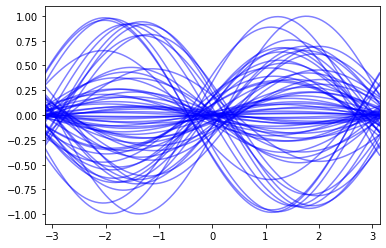

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [3]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

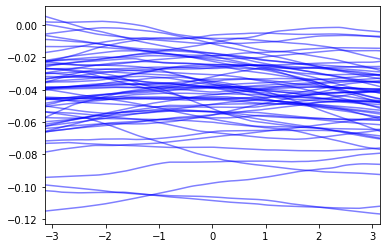

In [4]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [6]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context_range = (4, 4)
num_extra_target_range = (4, 4)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=num_context_range,
                                  num_extra_target_range=num_extra_target_range, 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 5.851
iteration 400, loss 7.814
iteration 600, loss 0.941
iteration 800, loss 4.042
iteration 1000, loss 4.940
Epoch: 0, Avg_loss: 3.0881886537857355
iteration 1200, loss -1.719
iteration 1400, loss -1.182
iteration 1600, loss 6.573
iteration 1800, loss -6.859
iteration 2000, loss -4.709
Epoch: 1, Avg_loss: 1.943629755290225
iteration 2200, loss -0.496
iteration 2400, loss 4.967
iteration 2600, loss 0.090
iteration 2800, loss 7.799
iteration 3000, loss -5.544
Epoch: 2, Avg_loss: 1.8939086077027023
iteration 3200, loss 6.928
iteration 3400, loss 2.736
iteration 3600, loss 5.635
iteration 3800, loss 0.413
iteration 4000, loss 7.895
Epoch: 3, Avg_loss: 1.892775287195109
iteration 4200, loss 2.315
iteration 4400, loss 0.028
iteration 4600, loss -0.343
iteration 4800, loss 5.772
iteration 5000, loss -0.974
Epoch: 4, Avg_loss: 1.8113108140784315
iteration 5200, loss 6.861
iteration 5400, loss 6.813
iteration 5600, loss 5.356
iteration 5800, loss -0.161
iteration 6000, los

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

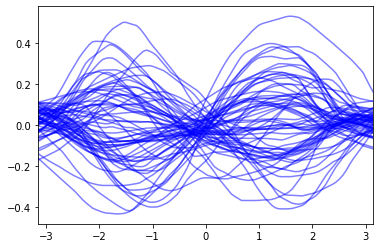

In [7]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

In [126]:
from utils import context_target_split

num_context = 10
num_target = 100 - num_context

# Extract a batch from data_loader
batch = next(iter(data_loader))

# Use batch to create random set of context points
x, y = batch
x_context, y_context, x_target, y_target = context_target_split(x[0:1], y[0:1], num_context, num_target)

# # Create a set of target points corresponding to entire [-pi, pi] range
# # x_target = torch.Tensor(np.linspace(-pi, pi, 100))
# # x_target = x_target.unsqueeze(1).unsqueeze(0)
x_target = x_target[0]
y_target = y_target[0]
inds = torch.argsort(x_target.squeeze(-1), axis=0)
x_target = x_target[inds].unsqueeze(0)
y_target = y_target[inds]

Text(0.5, 1.0, 'NP')

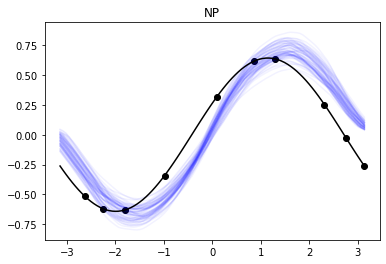

In [127]:
neuralprocess.training = False
for i in range(64): #range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    std = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')
#     plt.plot(x_target.numpy()[0], mu.numpy()[0] + std.numpy()[0], 
#              alpha=0.05, c='b')
#     plt.plot(x_target.numpy()[0], mu.numpy()[0] - std.numpy()[0], 
#              alpha=0.05, c='b')
plt.plot(x_target.numpy()[0], y_target.numpy(), color='k')
plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')
plt.title('NP')

In [128]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF

In [129]:
x_train, y_train = x_context[0].numpy(), y_context[0].numpy()

# print(x_train, y_train)

# kernel
# kernel = ConstantKernel(1.0, (1e-1, 1e3)) * RBF(10.0, (1e-3, 1e3))
gp = gaussian_process.GaussianProcessRegressor()
gpr = gp.fit(x_train, y_train)
gpr.kernel_.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=1),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': 'fixed',
 'k2__length_scale': 1.0,
 'k2__length_scale_bounds': 'fixed'}

In [130]:
x_test = x_target[0].numpy()

mu, std = gpr.predict(x_test, return_std=True)
mu, std = mu.flatten(), std.flatten()

Text(0.5, 1.0, 'GP')

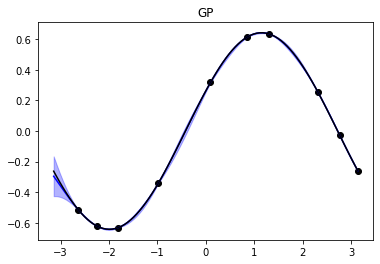

In [131]:
plt.plot(x_test.flatten(), mu, color='b')
plt.fill_between(x_test.flatten(), mu - std, mu + std, color='b', alpha=0.3)
plt.plot(x_target.numpy()[0], y_target.numpy(), color='k')
plt.scatter(x_train.flatten(), y_train.flatten(), c='k')
plt.title('GP')